In [31]:
import numpy as np
# from scipy.interpolate import interp1d
from scipy.optimize import bisect
# from tqdm.notebook import tqdm,trange

import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.latex.preamble': r'\usepackage{amsmath}',
    'text.usetex': True,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica']
})

# Setup

In [2]:
def step_Euler(func,t0,q0,h):
    t1 = t0 + h
    q1 = q0 + h*func(q0,t0)
    return t1,q1,h

In [3]:
def step_RKF45(func,t0,q0,h,tol,adaptive=True):
    A = np.array([
        [0,0,0,0,0,0],
        [1/4,0,0,0,0,0],
        [3/32,9/32,0,0,0,0],
        [1932/2197,-7200/2197,7296/2197,0,0,0],
        [439/216,-8,3680/513,-845/4104,0,0],
        [-8/27,2,-3544/2565,1859/4104,-11/40,0]
    ])
    B = np.array([0,1/4,3/8,12/13,1,1/2])
    
    K   = np.zeros((6,q0.shape[0]))
    for i in range(6):
        K[i] = h*func(q0+np.einsum('i,ij',A[i],K),t0+B[i]*h)
    
    t1  = t0 + h
    C   = np.array([16/135,0,6656/12825,28561/56430,-9/50,2/55])
    q1  = q0 + np.einsum('i,ij',C,K)
    
    D   = np.array([1/360,0,-128/4275,-2197/75240,1/50,2/55])
    err = np.abs(max(np.einsum('i,ij',D,K) + 1e-100)) # possibly change
    
    if err < tol or not adaptive:
        if adaptive:
            h1 = min(0.9*h*(tol/err)**(1/6),2*h)
        else:
            h1 = h
        return t1,q1,h1
    else:
        h1 = min(0.9*h*(tol/err)**(1/6),h/2)
        return step_RKF45(func,t0,q0,h1,tol)

In [4]:
def solve_ODE(func,t0,q0,h,stop=lambda t_res,q_res: False,tol=1e-8,method='RKF45',max_iter=int(1e6),adaptive=True):
    if method == 'RKF45':
        step_func = lambda t0_,q0_,h_: step_RKF45(func,t0_,q0_,h_,tol,adaptive)
    elif method == 'modified Euler':
        step_func = lambda t0_,q0_,h_: step_mod_Euler(func,t0_,q0_,h_)
    elif method == 'Euler':
        step_func = lambda t0_,q0_,h_: step_Euler(func,t0_,q0_,h_)
    
    t_results = [t0]
    q_results = [q0]
    for i in range(max_iter):
        t1,q1,h = step_func(t_results[-1],q_results[-1],h)
        t_results.append(t1)
        q_results.append(q1)
        
        if stop(t_results,q_results):
            break
            
    return np.array(t_results),np.array(q_results)

In [5]:
def get_derivative(y,x):
    e1   = (y[1] - y[0])/(x[1] - x[0])
    temp = (y[2:] - y[:-2])/(x[2:] - x[:-2])
    en   = (y[-1] - y[-2])/(x[-1] - x[-2])
    temp = np.array([e1]+list(temp)+[en])
    return temp

# Test projectile motion

In [ ]:
g=10
def f(q,t):
    return np.array([q[2],q[3],0,-g])

In [ ]:
def stop(t_res,q_res):
    return q_res[-1][1] <= 0

In [ ]:
v0 = 1
th = 45*(np.pi/180)
q0 = np.array([0,0,v0*np.cos(th),v0*np.sin(th)])

t0 = 0
h  = 1e-6
t,q = solve_ODE(f,t0,q0,h,stop,method='RKF45',tol=1e-16,adaptive=True)    
x,y,vx,vy = q.T

In [ ]:
T = np.linspace(t[0],t[-1],100)
x_exact = q0[0] + q0[2]*T
y_exact = q0[1] + q0[3]*T - g/2*T**2

# plt.scatter(t,(x - x_exact)/x_exact,label=r'$x$')
# plt.scatter(t,(y - y_exact)/y_exact,label=r'$y$')
plt.scatter(x,y,alpha=0.5)
plt.plot(x_exact,y_exact,'k--',alpha=0.7)
# plt.legend()
plt.xlabel(r'$x$',size=20)
plt.ylabel(r'$y$',size=20)
plt.tick_params(axis='both',which='major',direction='in',labelsize=20)

plt.show()

# Part 1 -- fixed target at origin

In [11]:
def F_coulomb(x1,x2,Z1=1,Z2=1):
    return Z1*Z2*(x1 - x2)/np.sqrt(np.sum((x1 - x2)**2))**3

In [12]:
def f(q,t,m1=1,Z1=1,Z2=1):
    return np.array([q[2],q[3],*F_coulomb(q[[0,1]],np.array([0,0]),Z1,Z2)/m1])

### Test

In [13]:
x0 = -50
b  = 3
v0 = 1
q0 = np.array([x0,b,v0,0])

t0 = 0
tf = 10
N = 10000
h = (tf - t0)/N

def stop(t_res,q_res,atol=1e-6,rtol=1e-6):
    th_p  = np.arctan(q_res[-2][3]/q_res[-2][2])
    th_c  = np.arctan(q_res[-1][3]/q_res[-1][2])
    cond1 = np.abs(th_p - th_c) < atol or np.abs(1 - th_c/(th_p + 1e-100)) < rtol
    cond2 = np.sum(q_res[-1][:2]**2) - np.sum(q_res[0][:2]**2) > 0
    
    return cond1 and cond2

In [14]:
t,q = solve_ODE(f,t0,q0,h,stop,method='RKF45',tol=1e-6,adaptive=False)    
x,y,vx,vy = q.T

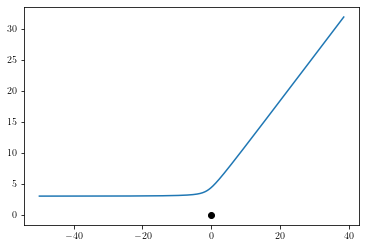

In [15]:
plt.plot(x,y)
plt.plot([0],[0],color='k',marker='o')
plt.show()

### calculate $b(\theta)$

In [ ]:
b = np.logspace(-3,2,50)
q_results = np.zeros((b.shape[0],4))
for i in range(b.shape[0]):
    q0 = np.array([x0,b[i],v0,0])
    t,q = solve_ODE(lambda q_,t_: f(q_,t_,Z1=1,Z2=2),t0,q0,h,stop,method='RKF45',tol=1e-16,adaptive=True)
    q_results[i] = q[-1]
    
    x,y,vx,vy = q.T
    plt.plot(x,y)
plt.show()

theta = np.arctan2(q_results[:,3],q_results[:,2])
dsig = b**2*np.log(10)/np.sin(theta)/np.abs(get_derivative(theta,np.log10(b)))

In [ ]:
nrows,ncols = 1,2
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

Z1,Z2,m1 = 1,2,1

exact = 2*np.arctan(Z1*Z2/b/m1/v0**2)
ax[0].plot(b,theta,ls='None',marker='o',color='c',alpha=0.6,label=r'$\rm numeric~approximation$')
ax[0].plot(b,exact,'k-',alpha=0.5,label=r'$\rm analytic~solution$')
ax[0].legend(fontsize=20,loc='lower left',frameon=False)

ax[0].set_xlabel(r'$b$',size=30)
ax[0].text(s=r'\boldmath $\theta$',x=0.95,y=0.95,size=30,ha='right',va='top',transform=ax[0].transAxes)
ax[0].tick_params(axis='both',which='major',direction='in',labelsize=20,pad=7)
ax[0].semilogx()

yticks  = [0,np.pi/4,np.pi/2,3*np.pi/4,np.pi]
ylabels = [r'$0$',r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$',r'$\pi$']
ax[0].set_yticks(yticks,ylabels)


exact = (Z1*Z2/4/(m1*v0**2/2)/np.sin(theta/2)**2)**2
ax[1].plot(theta,dsig,ls='None',marker='o',color='c',alpha=0.5)
ax[1].plot(theta,exact,'k-')

ax[1].set_xlabel(r'$\theta$',size=30)
ax[1].text(s=r'\boldmath $\displaystyle \frac{{\rm d} \sigma}{{\rm d} \Omega}$',x=0.95,y=0.95,size=30,ha='right',va='top',transform=ax[1].transAxes)
# ax[1].set_ylabel(,size=30)
ax[1].tick_params(axis='both',which='major',direction='in',labelsize=20)
ax[1].tick_params(axis='both',which='minor',direction='in')
ax[1].semilogy()

xticks  = [0,np.pi/4,np.pi/2,3*np.pi/4,np.pi]
xlabels = [r'$0$',r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$',r'$\pi$'] 
ax[1].set_xticks(xticks,xlabels)

fig.tight_layout()
plt.show()
fig.savefig(r'part1.pdf',bbox_inches='tight')

# Part 2 -- moving target

In [65]:
def f(q,t,m1=1,m2=1,Z1=1,Z2=1):
    F_ = F_coulomb(q[[0,1]],q[[4,5]],Z1,Z2)
    return np.array([*q[[2,3]],*(F_/m1),*q[[6,7]],*(-F_/m2)])

In [66]:
x0 = -50
b  = 3
v0 = 1
q0 = np.array([x0,b,v0,0,0,0,0,0])

t0 = 0
tf = 10
N = 10000
h = (tf - t0)/N

def stop(t_res,q_res,atol=1e-6,rtol=1e-6):
    th_p  = np.arctan(q_res[-2][3]/q_res[-2][2])
    th_c  = np.arctan(q_res[-1][3]/q_res[-1][2])
    cond1 = np.abs(th_p - th_c) < atol or np.abs(1 - th_c/(th_p + 1e-100)) < rtol
    cond2 = np.sum(q_res[-1][:2]**2) - np.sum(q_res[0][:2]**2) > 0
    
    return cond1 and cond2

In [67]:
t,q = solve_ODE(f,t0,q0,h,stop,method='RKF45',tol=1e-16,adaptive=True)
x1,y1,vx1,vy1,x2,y2,vx2,vy2 = q.T

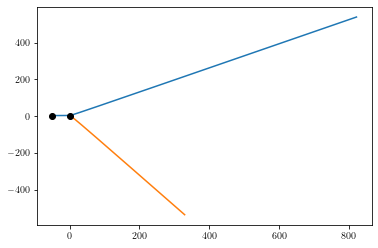

In [68]:
plt.plot(x1,y1)
plt.plot(*[x0,b],color='k',marker='o')

plt.plot(x2,y2)
plt.plot(*[0,0],color='k',marker='o')

plt.show()

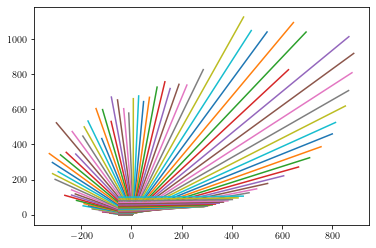

In [69]:
b = np.logspace(-3,2,100)
q_results = np.zeros((b.shape[0],8))
Z1,Z2,m1,m2 = 1,1,1,1
for i in range(b.shape[0]):
    q0 = np.array([x0,b[i],v0,0,0,0,0,0])
    t,q = solve_ODE(lambda q_,t_: f(q_,t_,m1=m1,m2=m2,Z1=Z1,Z2=Z2),t0,q0,h,stop,method='RKF45',tol=1e-16,adaptive=True)
    q_results[i] = q[-1]
    
    x1,y1,vx1,vy1,x2,y2,vx2,vy2 = q.T
    plt.plot(x1,y1)
plt.show()

chi  = np.arctan2(q_results[:,3],q_results[:,2])
dsig = b**2*np.log(10)/np.sin(chi)/np.abs(get_derivative(chi,np.log10(b)))

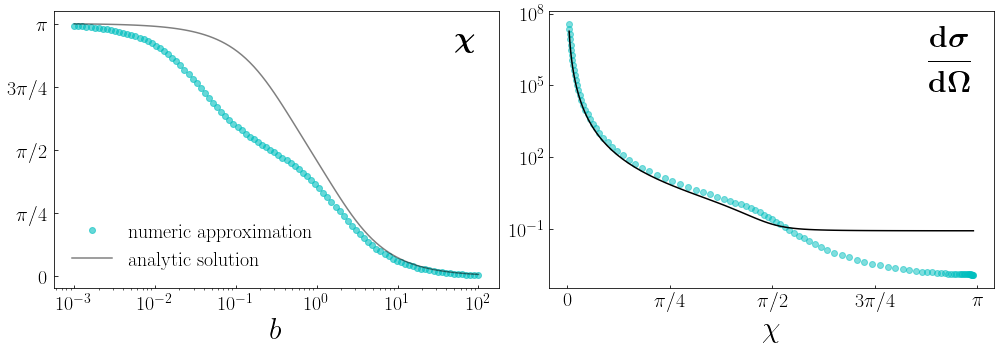

In [70]:
nrows,ncols = 1,2
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

mu = m1*m2/(m1+m2)
lam = np.sqrt(m1*mu)/m2
theta_exact = 2*np.arctan(Z1*Z2/b/mu/v0**2)
chi_exact = np.arctan2(np.sin(theta_exact),np.cos(theta_exact) + lam)
ax[0].plot(b,chi,ls='None',marker='o',color='c',alpha=0.6,label=r'$\rm numeric~approximation$')
ax[0].plot(b,chi_exact,'k-',alpha=0.5,label=r'$\rm analytic~solution$')
ax[0].legend(fontsize=20,loc='lower left',frameon=False)

ax[0].set_xlabel(r'$b$',size=30)
ax[0].text(s=r'\boldmath $\chi$',x=0.95,y=0.95,size=30,ha='right',va='top',transform=ax[0].transAxes)
ax[0].tick_params(axis='both',which='major',direction='in',labelsize=20,pad=7)
ax[0].semilogx()

yticks  = [0,np.pi/4,np.pi/2,3*np.pi/4,np.pi]
ylabels = [r'$0$',r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$',r'$\pi$']
ax[0].set_yticks(yticks,ylabels)

Jac   = np.sqrt(1 + 2*lam*np.cos(theta_exact) + lam**2)**3/(1 + lam*np.cos(theta_exact))
exact = Jac*(Z1*Z2/4/(mu*v0**2/2)/np.sin(theta_exact/2)**2)**2
ax[1].plot(chi,dsig,ls='None',marker='o',color='c',alpha=0.5)
ax[1].plot(chi,exact,'k-')

ax[1].set_xlabel(r'$\chi$',size=30)
ax[1].text(s=r'\boldmath $\displaystyle \frac{{\rm d} \sigma}{{\rm d} \Omega}$',x=0.95,y=0.95,size=30,ha='right',va='top',transform=ax[1].transAxes)
# ax[1].set_ylabel(,size=30)
ax[1].tick_params(axis='both',which='major',direction='in',labelsize=20)
ax[1].tick_params(axis='both',which='minor',direction='in')
ax[1].semilogy()

xticks  = [0,np.pi/4,np.pi/2,3*np.pi/4,np.pi]
xlabels = [r'$0$',r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$',r'$\pi$'] 
ax[1].set_xticks(xticks,xlabels)

fig.tight_layout()
plt.show()
fig.savefig(r'part1.pdf',bbox_inches='tight')